In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import pandas as pd
import requests
from lxml import html
import time
import wikipedia
from lxml import etree
import requests
from bs4 import BeautifulSoup

In [2]:
def read_csv(filename, file_type):
    data = []
    with open(filename, 'r') as csvfile:
        csvreader = csv.reader(csvfile, delimiter='\n')
        curr = []
        for line in csvreader:
            try:
                if file_type == 'companies':
                    if line[0].startswith('c:'):
                        if curr != []:
                            data.append(curr)
                        curr = line[0].split(';')
                        for j in range(1,len(curr)):
                            curr[j] = curr[j][1:-1]
                    else:
                        curr[-1] += ' ' + line[0].split(';')
                else:
                    curr = line[0].split(';')
                    for j in range(1,len(curr)):
                        curr[j] = curr[j][1:-1]
                    data.append(curr)
            except:
                pass
    if file_type != 'companies':
        data.pop(0)
    return data

In [3]:
people = read_csv('./data/crunchbase_data/people.csv', 'people')
degrees = read_csv('./data/crunchbase_data/degrees.csv', 'degrees')
companies = read_csv('./data/crunchbase_data/objects.csv', 'companies')
relationships = read_csv('./data/crunchbase_data/relationships.csv', 'relationships')
milestones = read_csv('./data/crunchbase_data/milestone.csv', 'milestones')
funding_rounds = read_csv('./data/crunchbase_data/funding_rounds.csv', 'funding_rounds')

In [4]:
len(people), len(degrees), len(companies)

(226709, 109610, 196553)

In [5]:
companies_dict = {}
for i in range(len(companies)):
    if companies[i][0].startswith('c:'):
        if companies[i][4] not in companies_dict:
            companies_dict[companies[i][4]] = companies[i]

In [6]:
unique_companies = {}
for i in range(len(people)):
    if people[i][-1].lower() not in unique_companies:
        unique_companies[people[i][-1]] = 1

In [7]:
len(unique_companies)

27227

In [8]:
id_to_degree = {}
for i in range(len(degrees)):
    try:
        id_to_degree[degrees[i][1]] = degrees[i]
    except:
        pass

In [9]:
company_to_id = {}
for i in range(len(companies)):
    try:
        unique_companies[companies[i][4]]
        company_to_id[companies[i][0]] = companies[i][4]
    except:
        pass

In [10]:
len(company_to_id)

22906

In [11]:
funding_round_by_company = {}
for i in range(len(funding_rounds)):
    try:
        company = company_to_id[funding_rounds[i][2]]
        if company not in funding_round_by_company:
            funding_round_by_company[company] = {}
        funding_round_by_company[company][funding_rounds[i][4]] = float(funding_rounds[i][6])
    except:
        pass

In [12]:
def duckduckgo_search(keywords, max_results=None):
    url = 'https://duckduckgo.com/html/'
    params = {
        'q': keywords,
        's': '0',
    }

    yielded = 0
    while True:
        res = requests.post(url, data=params)
        doc = html.fromstring(res.text)

        results = [a.get('href') for a in doc.cssselect('#links .links_main a')]
        for result in results:
            yield result
            time.sleep(0.1)
            yielded += 1
            if max_results and yielded >= max_results:
                return

        try:
            form = doc.cssselect('.results_links_more form')[-1]
        except IndexError:
            return
        params = dict(form.fields)

In [14]:
# USER_AGENT = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'}
 
# def fetch_results(search_term, number_results, language_code):
#     assert isinstance(search_term, str), 'Search term must be a string'
#     assert isinstance(number_results, int), 'Number of results must be an integer'
#     escaped_search_term = search_term.replace(' ', '+')
 
#     google_url = 'https://www.google.com/search?q={}&num={}&hl={}'.format(escaped_search_term, number_results, language_code)
#     response = requests.get(google_url, headers=USER_AGENT)
#     response.raise_for_status()
 
#     return search_term, response.text

In [15]:
# def parse_results(html, keyword):
#     soup = BeautifulSoup(html, 'html.parser')
 
#     found_results = []
#     rank = 1
#     result_block = soup.find_all('div', attrs={'class': 'g'})
#     for result in result_block:
 
#         link = result.find('a', href=True)
#         title = result.find('h3', attrs={'class': 'r'})
#         description = result.find('span', attrs={'class': 'st'})
#         if link and title:
#             link = link['href']
#             title = title.get_text()
#             if description:
#                 description = description.get_text()
#             if link != '#':
#                 found_results.append(link)
#                 rank += 1
#     return found_results

In [16]:
# def scrape_google(search_term, number_results, language_code):
#     try:
#         keyword, html = fetch_results(search_term, number_results, language_code)
#         results = parse_results(html, keyword)
#         return results
#     except AssertionError:
#         raise Exception("Incorrect arguments parsed to function")
#     except requests.HTTPError:
#         raise Exception("You appear to have been blocked by Google")
#     except requests.RequestException:
#         raise Exception("Appears to be an issue with your connection")

In [17]:
def get_revenue_wiki(url):
    if ' ' in url:
        url = url.replace(' ', '_')
        url += '_(company)'

    html = requests.get(url)

    #turn the HTML into a beautiful soup text object
    b = BeautifulSoup(html.text, 'html.parser')
    tables = b.findAll("table", { "class" : "infobox vcard" })

    text_tables = []
    for table in tables:
        text_tables.append(table.text)

    table_list = text_tables[0].split('\n')
    table_list = [x for x in table_list if x != '']
    return table_list

In [18]:
revenue = {}

for company in unique_companies:
    if len(revenue) == 100:
        break
    try:
        query = companies_dict[company][11] + ' wikipedia'
        for link in duckduckgo_search(query, max_results=10):
            if 'wikipedia.org' in link:
                print(link)
                print(company)
                revenue[company] = get_revenue_wiki(link)
                print(revenue[company])
                break
    except:
        pass

In [19]:
# wikipedia_pages = {}

# for company in unique_companies:
#     if len(wikipedia_pages) == 10:
#         break
#     try:
#         query = companies_dict[company][13]
#         for link in duckduckgo_search(query, max_results=10):
#             print(link)
#             if 'wikipedia' in link:
#                 wikipedia_pages[company] = link
#                 break
#     except:
#         pass

In [20]:
# net_incomes = {}
# for company in wikipedia_pages:
#     net_incomes.append(get_income_wiki(wikipedia_pages[company]))

In [21]:
founders = {}
for i in range(len(people)):
    full_name = people[i][2] + ' ' + people[i][3]
    if full_name in founders and founders[full_name]['id'] == people[i][1]:
        continue
    else:
        founders[full_name] = {}
        founders[full_name]['id'] = people[i][1]
        founders[full_name]['company'] = people[i][-1]

        try:
            founders[full_name]['company_id'] = companies_dict[people[i][-1]][0]
        except:
            founders[full_name]['company_id'] = []
        
        try:
            founders[full_name]['venture_round'] = funding_round_by_company[people[i][-1]]
        except:
            founders[full_name]['venture_round'] = []

        try:
            degree = id_to_degree[people[i][1]]
            founders[full_name]['degree'] = degree[2]
            founders[full_name]['majors'] = degree[3]
            founders[full_name]['school'] = degree[4]
        except:
            founders[full_name]['degree'] = []
            founders[full_name]['majors'] = []
            founders[full_name]['school'] = []

In [22]:
count = 0
for person in founders:
    print(founders[person])
    count += 1
    if count == 10:
        break

{'id': 'p:2', 'company': 'Blue Nile', 'company_id': 'c:4993', 'venture_round': {'series-c+': 0.0, 'series-b': 2000000.0}, 'degree': 'BS', 'majors': 'Applied Mathematics', 'school': 'University of California, Berkeley'}
{'id': 'p:3', 'company': 'Wetpaint', 'company_id': 'c:1', 'venture_round': {'series-a': 250000.0, 'series-b': 500000.0, 'series-c+': 5000000.0}, 'degree': 'MBA', 'majors': '', 'school': 'Indiana University'}
{'id': 'p:60744', 'company': 'Unaffiliated', 'company_id': [], 'venture_round': [], 'degree': [], 'majors': [], 'school': []}
{'id': 'p:5', 'company': 'Zoho', 'company_id': 'c:3', 'venture_round': [], 'degree': 'BS', 'majors': 'Biology, Psychology', 'school': 'McGill University'}
{'id': 'p:6', 'company': 'i/o Ventures', 'company_id': 'c:16441', 'venture_round': [], 'degree': '', 'majors': '', 'school': 'Montessori'}
{'id': 'p:7', 'company': 'Digg', 'company_id': 'c:4', 'venture_round': {'series-b': 500000.0, 'series-a': 800000.0, 'series-c+': 0.0}, 'degree': '', 'maj

In [23]:
company_founders = {}
for founder in founders:
    if founders[founder]['company'] not in company_founders:
        company_founders[founders[founder]['company']] = {}
        company_founders[founders[founder]['company']][founder] = founders[founder]
    elif founders[founder]['company'] in company_founders:
        company_founders[founders[founder]['company']][founder] = founders[founder]

In [24]:
company_founders['Facebook']

{"Adam D'Angelo": {'company': 'Facebook',
  'company_id': 'c:5',
  'degree': 'BS',
  'id': 'p:1531',
  'majors': 'Computer Science',
  'school': 'California Institute of Technology',
  'venture_round': {'angel': 0.0,
   'other': 0.0,
   'series-a': 2700000.0,
   'series-b': 7500000.0,
   'series-c+': 0.0,
   'venture': 500000000.0}},
 'Adam Marchick': {'company': 'Facebook',
  'company_id': 'c:5',
  'degree': 'BS',
  'id': 'p:106199',
  'majors': 'Computer Science',
  'school': 'Stanford University',
  'venture_round': {'angel': 0.0,
   'other': 0.0,
   'series-a': 2700000.0,
   'series-b': 7500000.0,
   'series-c+': 0.0,
   'venture': 500000000.0}},
 'Adam Michela': {'company': 'Facebook',
  'company_id': 'c:5',
  'degree': [],
  'id': 'p:184928',
  'majors': [],
  'school': [],
  'venture_round': {'angel': 0.0,
   'other': 0.0,
   'series-a': 2700000.0,
   'series-b': 7500000.0,
   'series-c+': 0.0,
   'venture': 500000000.0}},
 'Alison Rosenthal': {'company': 'Facebook',
  'company_

In [25]:
unique_degrees = {}
for founder in founders:
    try:
        degree = founders[founder]['degree']
        if degree in unique_degrees:
            unique_degrees[degree] += 1
        else:
            unique_degrees[degree] = 1
    except:
        continue

In [26]:
top_degrees = ['BA', 'BS', 'MBA', 'MS', 'PhD', 'BBA', 'JD', 'MA', 'BE']

In [27]:
unique_majors = {}
for founder in founders:
    try:
        majors = founders[founder]['majors']
        if majors in unique_majors:
            unique_majors[majors] += 1
        else:
            unique_majors[majors] = 1
    except:
        continue

In [28]:
top_majors = [x[0] for x in list(sorted(unique_majors.items(), key=lambda x: x[1], reverse=True)[1:100]) \
     if x[0] not in top_degrees and x[0] != 'Degree']

In [29]:
top_majors

['Computer Science',
 'Economics',
 'Electrical Engineering',
 'Business Administration',
 'Finance',
 'Accounting',
 'Mechanical Engineering',
 'Marketing',
 'Business',
 'Law',
 'Computer Engineering',
 'Engineering',
 'Political Science',
 'Physics',
 'Mathematics',
 'Psychology',
 'Management',
 'Chemistry',
 'History',
 'English',
 'Chemical Engineering',
 'Biology',
 'Industrial Engineering',
 'Business Management',
 'Information Technology',
 'Communications',
 'International Business',
 'Philosophy',
 'Journalism',
 'Biochemistry',
 'Entrepreneurship',
 'Software Engineering',
 'Civil Engineering',
 'Information Systems',
 'Graphic Design',
 'Sociology',
 'Commerce',
 'International Relations',
 'Computer Science and Engineering',
 'English Literature',
 'Electrical Engineering and Computer Science',
 'Electrical and Computer Engineering',
 'Electronic Engineering',
 'Medicine',
 'Computer Information Systems',
 'Management Information Systems',
 'Accounting and Finance',
 'Com

In [30]:
universities_count = {}
for i in range(len(degrees)):
    if degrees[i][4] not in universities_count:
        universities_count[degrees[i][4]] = 1
    else:
        universities_count[degrees[i][4]] += 1

In [31]:
unique_universities = list(sorted(universities_count.items(), key=lambda x: x[1], reverse=True))
top_universities = []
for school, count in unique_universities:
    if count >= 10:
        top_universities.append(school)

In [32]:
len(top_universities)

1307

In [33]:
baseline_founders = {}
for founder in founders:
    try:
        degree = founders[founder]['degree']
        if degree in top_degrees:
            school = founders[founder]['school']
            if school in top_universities:
                if founders[founder]['venture_round'] != []:
                    if founders[founder]['company'] != '"Unaffiliated"':
                        baseline_founders[founder] = founders[founder]
    except:
        pass

In [34]:
len(baseline_founders)

3782

In [35]:
baseline_companies = []
for founder in baseline_founders:
    company = baseline_founders[founder]['company']
    if company not in baseline_companies:
        baseline_companies.append(company)

In [36]:
len(baseline_companies)

2528

In [52]:
degree_features = np.zeros(len(top_majors))
schools_features = np.zeros(len(top_universities))

In [38]:
featurized_data = []
labels = []

for founder in baseline_founders:
    degree = list(top_degrees).index(baseline_founders[founder]['degree'])

    school = list(top_universities).index(baseline_founders[founder]['school'])

    funding = 0.
    for round_id in baseline_founders[founder]['venture_round']:
        funding += baseline_founders[founder]['venture_round'][round_id]

    labels.append(funding)
    featurized_data.append([degree,school])

In [39]:
for i in range(len(labels)):
    if labels[i] == 0.:
        labels[i] = 0
    elif labels[i] <= np.mean(labels)/2.and labels[i] > 0:
        labels[i] = 1
    elif labels[i] <= np.mean(labels) and labels[i] > np.mean(labels)/2.:
        labels[i] = 2
    elif labels[i] <= (3/2)*np.mean(labels) and labels[i] > np.mean(labels):
        labels[i] = 3
    else:
        labels[i] = 4

In [40]:
featurized_data = np.array(featurized_data)
labels = np.array(labels)

In [41]:
shuffled_indices = np.arange(0,len(labels))
np.random.shuffle(shuffled_indices)

In [42]:
train_data = np.array([featurized_data[i] for i in shuffled_indices[:int(len(shuffled_indices)*0.8)]])
test_data = np.array([featurized_data[i] for i in shuffled_indices[int(len(shuffled_indices)*0.8):]])

train_labels = np.array([labels[i] for i in shuffled_indices[:int(len(shuffled_indices)*0.8)]])
test_labels = np.array([labels[i] for i in shuffled_indices[int(len(shuffled_indices)*0.8):]])

In [49]:
lr = LogisticRegression()
lr.fit(train_data, train_labels).score(test_data, test_labels)

0.3474240422721268

In [50]:
test_labels

array([2, 1, 2, 1, 1, 4, 1, 0, 3, 1, 0, 3, 3, 4, 1, 0, 1, 3, 4, 0, 1, 3,
       2, 0, 1, 3, 0, 4, 4, 4, 4, 1, 1, 4, 0, 1, 0, 1, 1, 0, 2, 2, 0, 1,
       4, 4, 1, 1, 4, 1, 0, 4, 1, 4, 1, 3, 1, 0, 4, 0, 1, 0, 4, 0, 0, 4,
       4, 0, 4, 1, 1, 0, 2, 1, 1, 1, 4, 1, 4, 1, 0, 4, 0, 1, 3, 4, 0, 0,
       0, 0, 0, 4, 0, 0, 4, 0, 1, 0, 3, 1, 0, 4, 0, 4, 0, 0, 4, 4, 1, 1,
       4, 0, 0, 1, 0, 4, 4, 0, 4, 0, 0, 4, 4, 0, 0, 0, 4, 4, 0, 0, 1, 1,
       4, 3, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 3, 0, 1, 1, 0, 1, 4, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 4, 1, 1, 1, 1, 0, 0, 2, 2, 1, 0, 4, 0, 4,
       0, 0, 2, 0, 1, 1, 1, 1, 3, 4, 0, 2, 4, 1, 0, 1, 2, 1, 0, 3, 3, 1,
       0, 0, 1, 0, 1, 1, 0, 2, 4, 1, 0, 1, 1, 2, 0, 0, 4, 1, 0, 4, 1, 1,
       2, 1, 4, 0, 4, 4, 0, 4, 1, 0, 1, 1, 4, 1, 1, 3, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 4, 1, 1, 1, 0, 4, 1, 1, 4, 3, 0, 0, 0, 2, 1, 4,
       1, 1, 0, 0, 1, 4, 1, 1, 1, 3, 1, 1, 0, 1, 1, 1, 4, 1, 1, 0, 0, 4,
       1, 3, 0, 0, 1, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0,

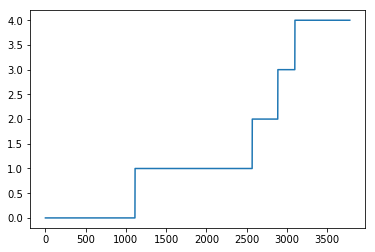

In [53]:
plt.plot(sorted(labels))
plt.show()